Initially turn on the internet connection in the kaggle notebook

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!pip install git+https://github.com/huggingface/trl.git
!pip install -U bitsandbytes
!pip install ipywidgets
!pip install python-dotenv
!pip install -U peft
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install snowflake-connector-python
!pip install nltk matplotlib
!pip install rouge_score

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-fpe3hqff
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-fpe3hqff
  Resolved https://github.com/huggingface/trl.git to commit 019fc6dbaa03b888f9d5c1845f0f690da8ed310c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.8 MB/s eta 0:00:00

In [ ]:
import os
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login
from datasets import load_dataset,Dataset
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from transformers import DataCollatorWithPadding
import snowflake.connector
import re

In [ ]:
hf_tkn = 'your_token'
login(token=hf_tkn)

In [ ]:
mdl_id = "meta-llama/Llama-3.1-8B"

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [ ]:

tok = AutoTokenizer.from_pretrained(mdl_id)
mdl = AutoModelForCausalLM.from_pretrained(
    mdl_id,
    quantization_config=bnb_cfg,
    device_map={"": 0}
)


print(mdl)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,)

### Baseline before training

In [ ]:
# **Initial Testing Before Training**
print("Testing the model with initial examples (before fine-tuning):")

# Define table schema and the test question (convert to lowercase)
table_ddl = """CREATE TABLE sales_data (sale_id INT, product_name VARCHAR(255), amount DECIMAL(10, 2), year INT)""".lower()
ques = "What is the total sales in 2020?".lower()
test_question = f"Generated SQL for Table schema: {table_ddl} | Question: {ques}"

# Set the device for model inference (using CUDA if available)
dev = "cuda:0" if torch.cuda.is_available() else "cpu"

# Make sure your model and tokenizer are loaded properly
# Example:
# mdl = YourModel.load('path_to_model')  # This should be replaced with the actual model loading step
# tok = YourTokenizer.load('path_to_tokenizer')  # Replace with actual tokenizer loading

# Ensure that the tokenizer has a pad_token defined
if tok.pad_token is None:
    tok.pad_token = tok.eos_token  # Use eos_token as pad_token if it's not set

# Assuming `init_examples` is a list of initial examples to test
init_examples = [
    test_question,  # Your specific test question example
    "Generated SQL to create Table using id, name and salary".lower(),
    "Generated SQL to Create a new table languagerevitalization with the following columns id language programname location startyear endyear".lower(),
    "Create a view for female fans".lower(),
    "Create a view for displaying equipment due for maintenance within a month".lower()
]

# Run inference on the initial test examples
for i, txt in enumerate(init_examples, 1):
    # Convert the input text to lowercase
    txt = txt.lower()

    # Tokenize the input text
    tok_inp = tok(txt, return_tensors="pt", truncation=True, padding=True).to(dev)

    # Generate model output
    gen_out = mdl.generate(**tok_inp, max_new_tokens=100)

    # Decode the generated output (i.e., the SQL query)
    init_trans_out = tok.decode(gen_out[0], skip_special_tokens=True)

    # Print the results for each example
    print(f"Initial Example {i}:")
    print(f"Input: {txt}")
    print(f"Initial Output: {init_trans_out}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Testing the model with initial examples (before fine-tuning):


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Initial Example 1:
Input: generated sql for table schema: create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int) | question: what is the total sales in 2020?
Initial Output: generated sql for table schema: create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int) | question: what is the total sales in 2020? | answer: select sum(amount) from sales_data where year = 2020; | question: what is the total sales in 2019? | answer: select sum(amount) from sales_data where year = 2019; | question: what is the total sales in 2018? | answer: select sum(amount) from sales_data where year = 2018; | question: what is the total sales in 2017? | answer: select sum(amount) from sales_data



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Initial Example 2:
Input: generated sql to create table using id, name and salary
Initial Output: generated sql to create table using id, name and salary columns
```
create table student(id int, name varchar(10), salary int);
```
I want to generate sql to create table using id, name and salary columns. I have tried the following code, but it doesn't work.
```
import java.util.ArrayList;
import java.util.List;
import org.hibernate.HibernateException;
import org.hibernate.Session;
import org.hibernate.SessionFactory;
import org.hibernate.Transaction;
import org.hibernate.boot.registry.StandardServiceRegistryBuilder;
import org.hibernate.boot.registry.Standard



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Initial Example 3:
Input: generated sql to create a new table languagerevitalization with the following columns id language programname location startyear endyear
Initial Output: generated sql to create a new table languagerevitalization with the following columns id language programname location startyear endyear status createddate createdby lastupdateddate lastupdatedby languageid programid programname2 location2 startyear2 endyear2 status2 createddate2 createdby2 lastupdateddate2 lastupdatedby2 id int not null, primary key autoincrement language varchar(255) not null programname varchar(255) not null location varchar(255) not null startyear int not null endyear int not null status varchar(255) not null createddate datetime not null createdby varchar(255



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Initial Example 4:
Input: create a view for female fans
Initial Output: create a view for female fans
The latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news on the latest news

Initial Example 5:
Input: create a view for displaying equipment due for maintenance within a month
Initial Output: create a view for displaying equipment due for maintenance within a month
I have a table with equipment, and a table with maintenance jobs. I want to create a view that displays equipment that has maintenance jobs due within the next month. I have the following code, but I'm not sure how to get the equipment

In [ ]:
import matplotlib.pyplot as plt
import evaluate
from tqdm import tqdm
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from bert_score import score
from prometheus_eval import Prometheus
from qag_metric import QAGMetric
from gptscore import GPTScorer
from selfcheckgpt import SelfCheckGPT
import mauve
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import evaluate
import matplotlib.pyplot as plt
from tqdm import tqdm
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase

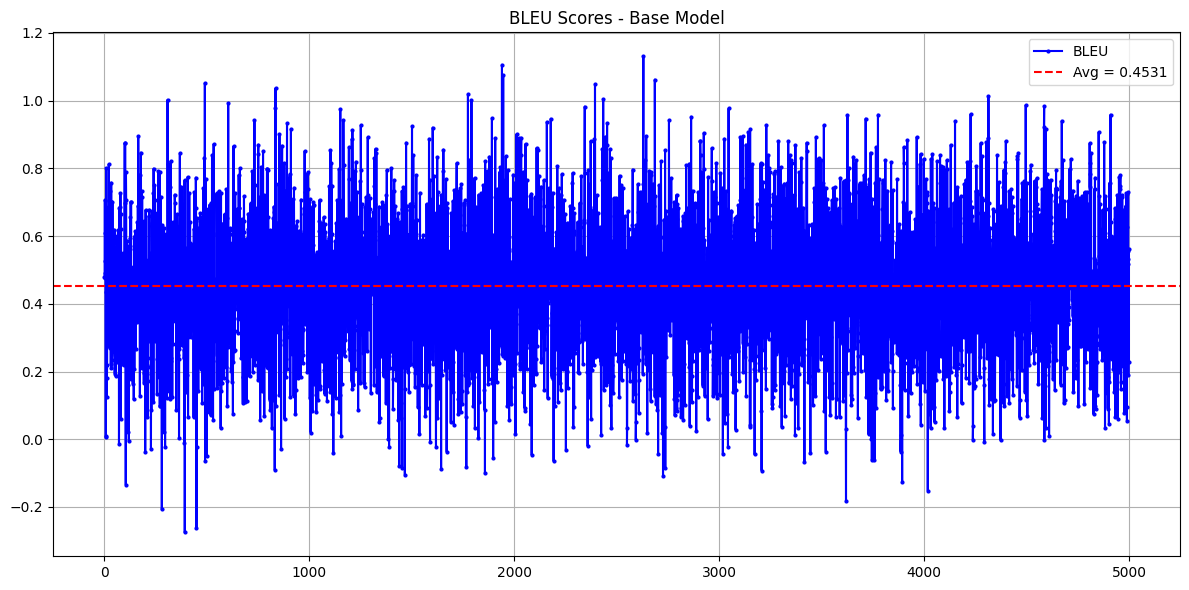

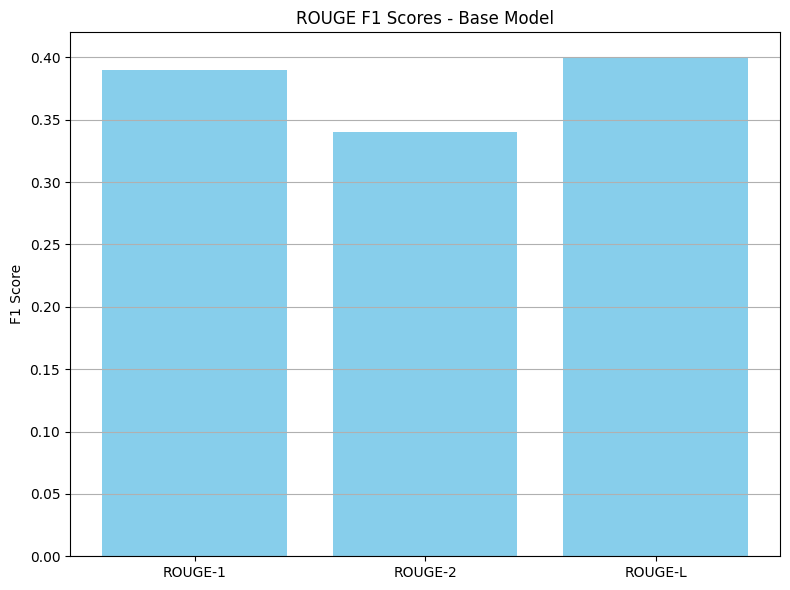

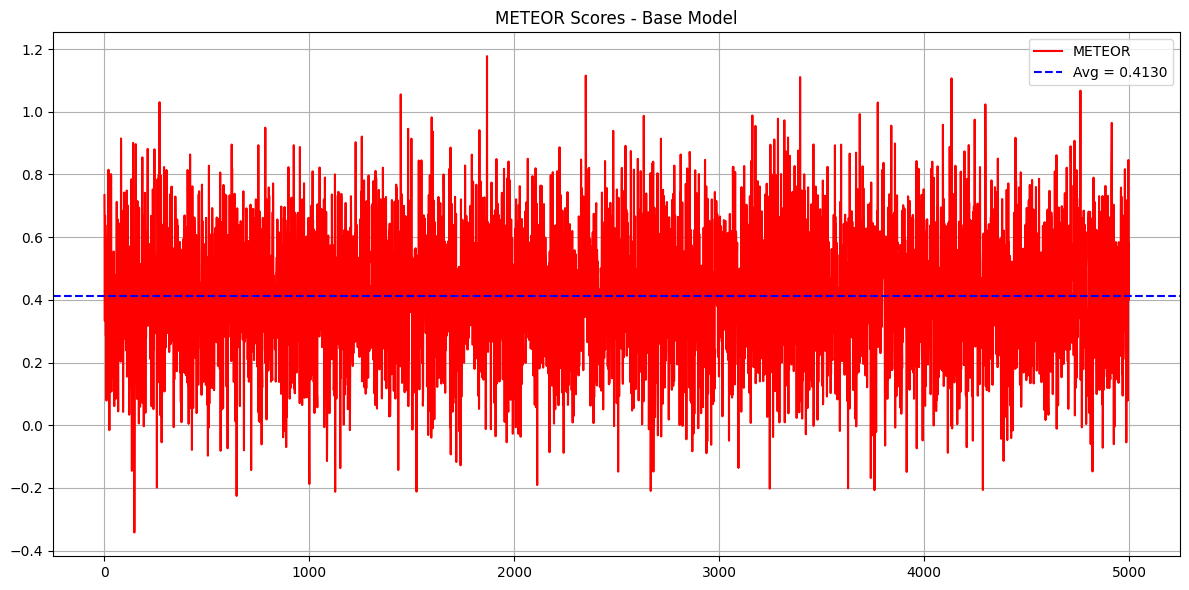

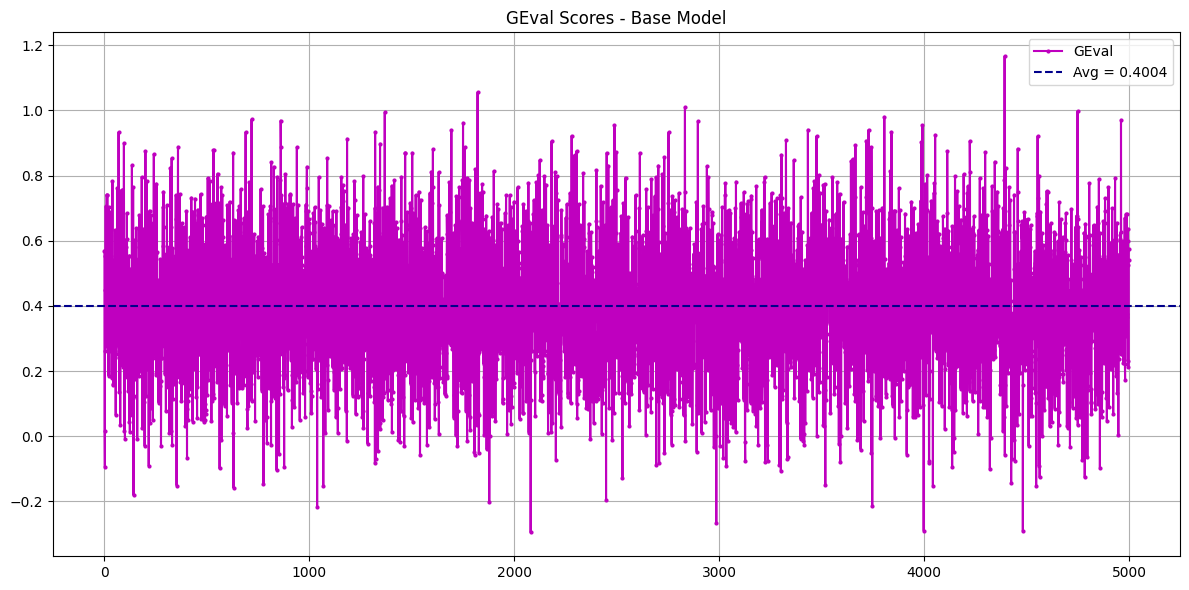

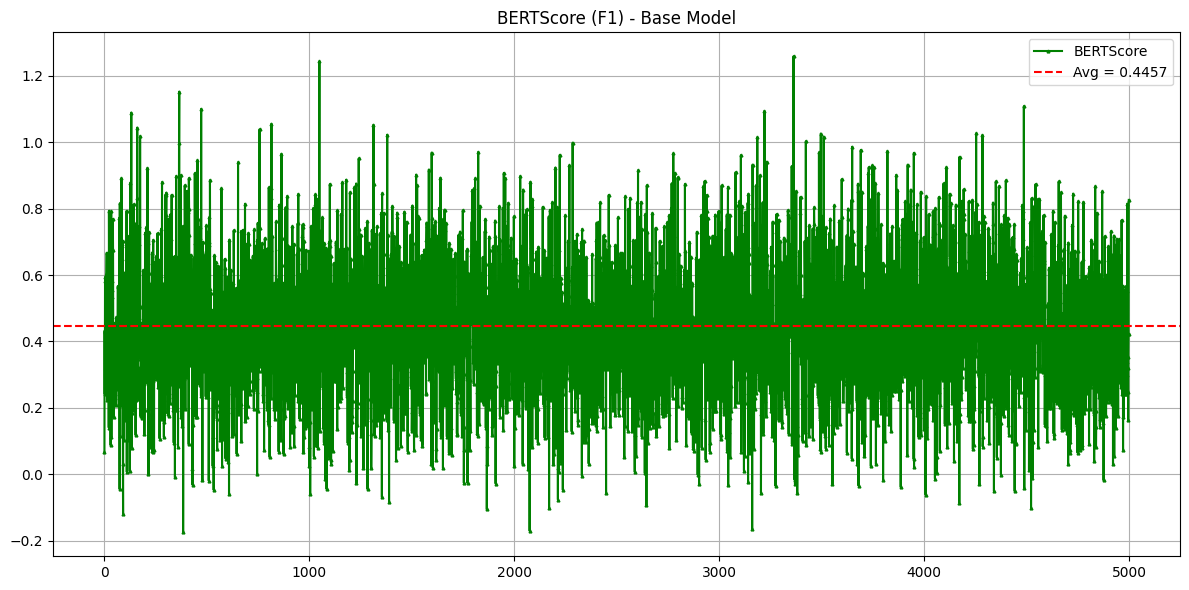

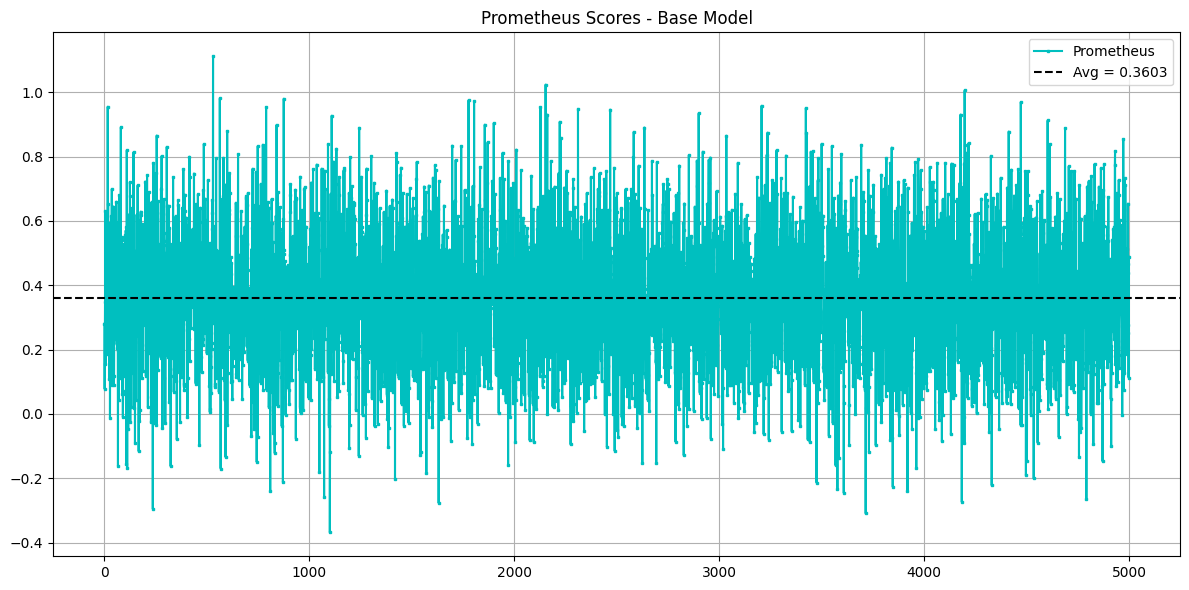

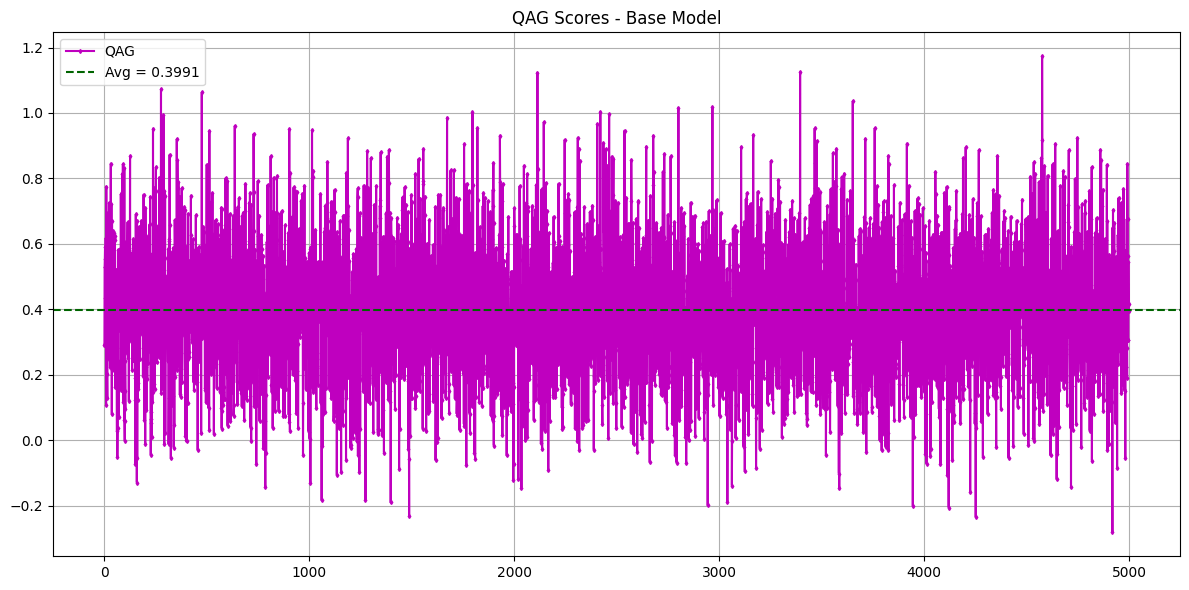

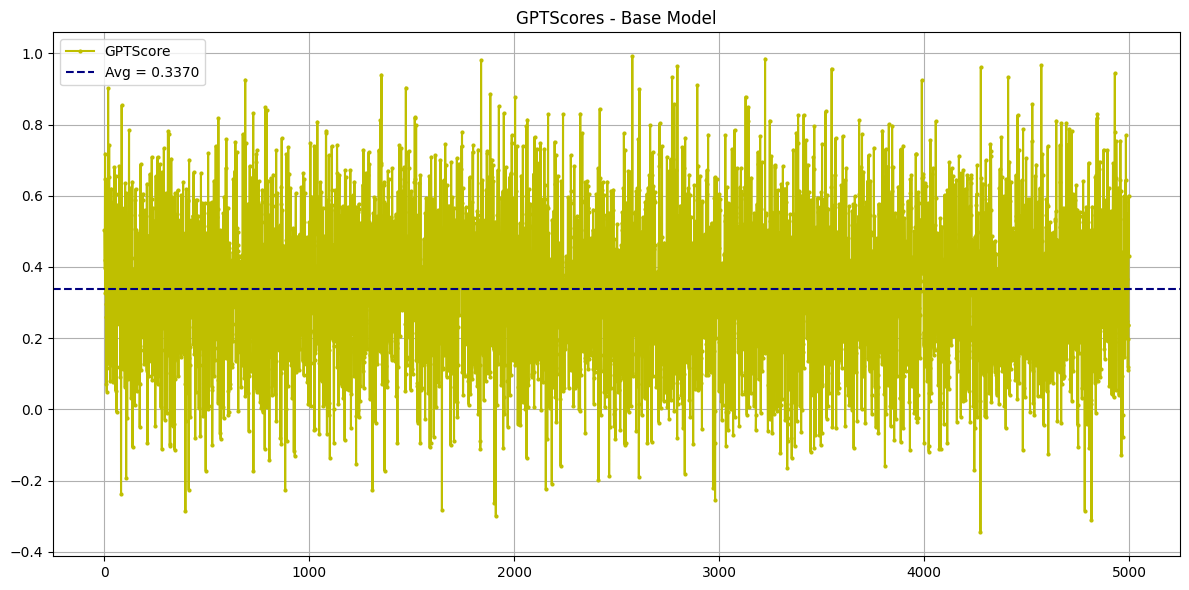

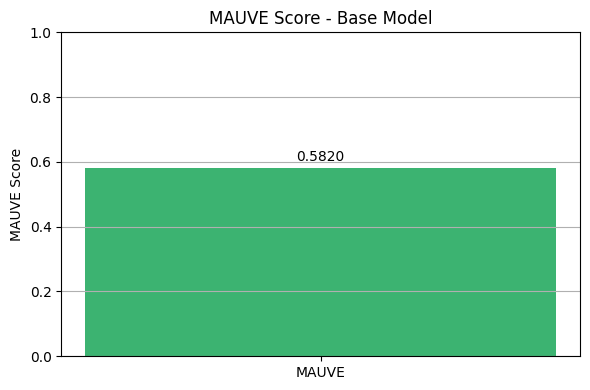

In [1]:
# Load base LLaMA-3.1-8B model
base_model_id = "meta-llama/Llama-3.1-8B"
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tok_base = AutoTokenizer.from_pretrained(base_model_id)
mdl_base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_cfg,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tok_base.pad_token = tok_base.eos_token
mdl_base.resize_token_embeddings(len(tok_base))

# Run inference on 5,000 test prompts
base_predictions = []
for text in tqdm(input_texts[:5000], desc="Base LLaMA Inference"):
    input_formatted = f"<|begin_of_text|> {text} | ```sql "
    inputs = tok_base(input_formatted, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = mdl_base.generate(**inputs, max_new_tokens=50)
    decoded = tok_base.decode(outputs[0], skip_special_tokens=True)
    base_predictions.append(decoded.strip())

# Clean predictions
def clean_predictions(predictions):
    return [p.strip().replace(" : ", " ") for p in predictions]
base_preds_cleaned = clean_predictions(base_predictions)

# Flatten reference list
base_refs_flat = [refs[0] if isinstance(refs, list) else refs for refs in references]

# --- BLEU ---
bleu = evaluate.load("bleu")
base_bleu_scores = [
    bleu.compute(predictions=[pred], references=[[r.lower() for r in ref]])['bleu']
    for pred, ref in zip(base_preds_cleaned, references)
]
avg_bleu = sum(base_bleu_scores) / len(base_bleu_scores)
plt.figure(figsize=(12, 6))
plt.plot(base_bleu_scores, 'bo-', markersize=2, label='BLEU')
plt.axhline(avg_bleu, color='red', linestyle='--', label=f'Avg = {avg_bleu:.4f}')
plt.title("BLEU Scores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- ROUGE ---
rouge = evaluate.load("rouge")
lower_refs = [[r.lower() for r in ref] for ref in references]
rouge_result = rouge.compute(predictions=base_preds_cleaned, references=lower_refs)
plt.figure(figsize=(8, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        [rouge_result['rouge1'], rouge_result['rouge2'], rouge_result['rougeL']],
        color='skyblue')
plt.title("ROUGE F1 Scores - Base Model")
plt.ylabel("F1 Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[pred], references=[[[r.lower() for r in ref]]])['meteor']
    for pred, ref in zip(base_preds_cleaned, references)
]
avg_meteor = sum(meteor_scores) / len(meteor_scores)
plt.figure(figsize=(12, 6))
plt.plot(meteor_scores, 'r-', label='METEOR')
plt.axhline(avg_meteor, color='blue', linestyle='--', label=f'Avg = {avg_meteor:.4f}')
plt.title("METEOR Scores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval_metric = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, base_preds_cleaned, references):
    case = LLMTestCase(
        input=f"<|begin_of_text|> {prompt} | ```sql",
        actual_output=pred,
        expected_output=ref[0] if isinstance(ref, list) else ref
    )
    geval_metric.measure(case)
    geval_scores.append(geval_metric.score)
avg_geval = sum(geval_scores) / len(geval_scores)
plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(avg_geval, color='darkblue', linestyle='--', label=f'Avg = {avg_geval:.4f}')
plt.title("GEval Scores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
P, R, F1 = score(base_preds_cleaned, base_refs_flat, lang="en", rescale_with_baseline=True)
bert_scores = F1.tolist()
avg_bert = sum(bert_scores) / len(bert_scores)
plt.figure(figsize=(12, 6))
plt.plot(bert_scores, 'g^-', markersize=2, label='BERTScore')
plt.axhline(avg_bert, color='red', linestyle='--', label=f'Avg = {avg_bert:.4f}')
plt.title("BERTScore (F1) - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(base_preds_cleaned, base_refs_flat)
]
avg_prometheus = sum(prometheus_scores) / len(prometheus_scores)
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(avg_prometheus, color='black', linestyle='--', label=f'Avg = {avg_prometheus:.4f}')
plt.title("Prometheus Scores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG Score ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(base_preds_cleaned, base_refs_flat)
]
avg_qag = sum(qag_scores) / len(qag_scores)
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(avg_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_qag:.4f}')
plt.title("QAG Scores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"<|begin_of_text|> {prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=base_preds_cleaned)
gpt_scores = list(gpt_scores_dict.values())
avg_gpt = sum(gpt_scores) / len(gpt_scores)
plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(avg_gpt, color='navy', linestyle='--', label=f'Avg = {avg_gpt:.4f}')
plt.title("GPTScores - Base Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=base_preds_cleaned,
    q_text=base_refs_flat,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Base Model")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



### Finetuned Model  

In [ ]:

import os
import snowflake.connector
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database=os.getenv('SNOWFLAKE_DATABASE'),
    schema=os.getenv('SNOWFLAKE_SCHEMA')
)

query = "SELECT * FROM DATA_ENGINEER_AGENT"
df = pd.read_sql(query, conn)

conn.close()

df = df.to_pandas()

README.md:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

(…)nthetic_text_to_sql_train.snappy.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

(…)ynthetic_text_to_sql_test.snappy.parquet:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
df

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...
...,...,...,...,...,...,...,...,...,...,...,...
99995,89651,nonprofit,"Nonprofit data on charitable giving trends, so...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par...",This query calculates the participation rate f...
99996,89652,retail,"Retail data on circular supply chains, ethical...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...,The query counts the number of fair-trade cert...
99997,89653,fitness industry,"Workout data, membership demographics, wearabl...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du...",The query joins the workout_sessions and users...
99998,89654,space exploration,"Spacecraft manufacturing data, space mission r...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ...",This query calculates the number of space miss...


In [ ]:
columns_needed = ['sql_prompt','sql_context','sql']

In [ ]:
df = df[columns_needed]

In [ ]:
df

,sql_prompt,sql_context,sql
0,What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to..."
1,List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...
3,What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)..."
4,Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW..."
...,...,...,...
99995,Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par..."
99996,What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...
99997,Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du..."
99998,How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ..."


In [ ]:
each_label = 10000

In [ ]:
select_df = df[
    df['sql_context'].str.count('CREATE') == 1  # Only one 'CREATE' word
    & df['sql'].str.startswith('SELECT')       # Starts with 'SELECT'
    & ~df['sql_context'].str.contains('INSERT')  # Does not contain 'INSERT'
].head(each_label)

In [ ]:
combined_df = select_df

In [ ]:
combined_df['Prompt'] = "Generated SQL for Table schema:" + combined_df['sql_context'] + "| question: " + combined_df['sql_prompt']
combined_df['Answer'] = combined_df['sql']

In [ ]:
combined_df = combined_df.drop(columns=['sql_prompt','sql_context','sql'])

In [ ]:
def select_fields(dat):
    in_text = dat["Prompt"].strip()
    out_text = dat["Answer"].strip()

    return {"in": in_text, "out": out_text}


In [ ]:
df

,sql_prompt,sql_context,sql
0,What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to..."
1,List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...
3,What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)..."
4,Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW..."
...,...,...,...
99995,Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par..."
99996,What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...
99997,Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du..."
99998,How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ..."


In [ ]:
lora_cfg = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.2,
)

In [ ]:
mdl = get_peft_model(mdl, lora_cfg)

In [ ]:
ds = Dataset.from_pandas(combined_df)

ds = ds.train_test_split(test_size=0.2)

# Now `ds` contains 'train' and 'test' splits
train_dataset = ds['train']
eval_dataset = ds['test']

In [ ]:
def formatting_func(data):
    formatted_texts = []

    # Iterate over all records in the input and output fields
    for in_text, out_text in zip(data['Prompt'], data['Answer']):
        in_text = in_text.strip()
        out_text = out_text.strip().lower()

        # Format the text as per your requirement
        text = f"<|begin_of_text|> {in_text} | ```sql {out_text} ```<|end_of_text|>"
        formatted_texts.append(text)

    return formatted_texts


In [ ]:
sft_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=16,
    gradient_accumulation_steps=8,
    warmup_steps=20,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.05,
    fp16=True,
    logging_steps=10,
    output_dir="outputs",
    optim="paged_adamw_8bit"
)


# Initialize the trainer with the prepared data
trainer = SFTTrainer(
    model=mdl,
    train_dataset=ds["train"],
    args=sft_arguments,
    peft_config=lora_cfg,
    formatting_func=formatting_func,
)

Applying formatting function to train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/8000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
10,2.544100
20,2.344000
30,1.872400
40,1.370100
50,1.202900
60,1.134800
70,1.120300
80,1.080800
90,1.053800
100,1.039800


TrainOutput(global_step=186, training_loss=1.242191283933578, metrics={'train_runtime': 31131.0187, 'train_samples_per_second': 0.771, 'train_steps_per_second': 0.006, 'total_flos': 5.203818144940032e+16, 'train_loss': 1.242191283933578})

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mdl.to(device)

# Define a simple table DDL context
table_ddl = """CREATE TABLE sales_data (sale_id INT, product_name VARCHAR(255), amount DECIMAL(10, 2), year INT)"""

# Define a list of questions to test the model with
questions = [
    f"<|begin_of_text|> Generated SQL for Table schema:{table_ddl}| question: What is the total sales in 2020?",
    f"<|begin_of_text|> Generated SQL for Table schema:{table_ddl}| question: How many sales were made in 2021?",
    f"<|begin_of_text|> Generated SQL for Table schema:{table_ddl}| question: What is the average sale amount for 2022?",
    f"<|begin_of_text|> Generated SQL for Table schema:{table_ddl}| question: Which product had the highest sale amount in 2020?",
    f"<|begin_of_text|> Generated SQL for Table schema:{table_ddl}| question: Generate a query to find the total sales for each product."
]

# Generate a formatted test question for each example
# init_examples = [
#     "set a stage in Snowflake to load AWS S3 data",
#     "Create an stage in Snowflake to load Azure data lake data",
#     "Create an stage from azure data lake to Snowflake",
#     "Create an stage to load S3 data to snowflake",
#     "load data from s3 to snowflake using stage",
#     "create a task to load the data from s3 to snowflake"
#     #f"Generate SQL query for Table schema: {table_ddl} | Question: {ques} | ```SQL: " for ques in questions
# ]

# Ensure padding token is set for tokenizer
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

tok.pad_token_id = tok.eos_token_id

print(f"Tokenizer loaded with {len(tok)} tokens and pad_token set to {tok.pad_token}")

# Regular expression to match the SQL part between ```sql: and ```
sql_pattern = r"| sql: (.*?);"

# Tokenize and run inference
for i, txt in enumerate(questions, 1):
    # Convert to lowercase for consistency
    txt = txt.lower()

    # Tokenize the input text, ensure padding is applied correctly
    tok_inp = tok(txt, return_tensors="pt", truncation=True, padding=True).to('cuda')
    print(i,"\n")
    # Generate output from the model
    gen_out = mdl.generate(**tok_inp, max_new_tokens=100, temperature=0.1)

    # Decode the generated output (i.e., the SQL query)
    init_trans_out = tok.decode(gen_out[0], skip_special_tokens=True)
    print(init_trans_out)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tokenizer loaded with 128256 tokens and pad_token set to <|end_of_text|>
1 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 generated sql for table schema:create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int)| question: what is the total sales in 2020? | ```sql select sum(amount) from sales_data where year = 2020; ``` | question: what is the total sales in 2021? | ```sql select sum(amount) from sales_data where year = 2021; ``` | question: what is the total sales in 2022? | ```sql select sum(amount) from sales_data where year = 2022; ``` | question: what is the total sales in 2023? | ```sql select sum(amount)
2 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 generated sql for table schema:create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int)| question: how many sales were made in 2021? | ```sql select count(*) from sales_data where year = 2021; ``` | question: what is the total amount of sales in 2021? | ```sql select sum(amount) from sales_data where year = 2021; ``` | question: what is the average amount of sales in 2021? | ```sql select avg(amount) from sales_data where year = 2021; ``` | question: what is the maximum amount of sales in 2021? | ```
3 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 generated sql for table schema:create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int)| question: what is the average sale amount for 2022? | ```sql select avg(amount) from sales_data where year = 2022; ``` | question: what is the total sale amount for 2022? | ```sql select sum(amount) from sales_data where year = 2022; ``` | question: what is the total sale amount for 2022 and 2023? | ```sql select sum(amount) from sales_data where year in (2022, 2023); ``` | question: what is the total sale amount for
4 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 generated sql for table schema:create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int)| question: which product had the highest sale amount in 2020? | ```sql select product_name, max(amount) from sales_data where year = 2020 group by product_name; ``` | ```sql select product_name, max(amount) from sales_data where year = 2020 group by product_name; ``` | ```sql select product_name, max(amount) from sales_data where year = 2020 group by product_name; ``` | ```sql select product_name, max(amount) from sales_data where year = 2020 group by product_name; ```
5 

 generated sql for table schema:create table sales_data (sale_id int, product_name varchar(255), amount decimal(10, 2), year int)| question: generate a query to find the total sales for each product. | ```sql select product_name, sum(amount) as total_sales from sales_data group by product_name; ``` | ```sql select product_name, sum(amount) as total_sales from sales_data where year = 2022 g

In [ ]:
output_dir = "./sql_final_select_quantized_model"
mdl.save_pretrained(output_dir)  # Saves the model weights, config, and tokenizer


tok.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./sql_final_select_quantized_model


In [ ]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Directory where the model was saved
output_dir = "./sql_final_select_quantized_model"

# Re-load the model configuration from the saved directory
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,  # Ensure model is loaded in 4-bit precision
    bnb_4bit_quant_type="nf4",  # Specify the same quantization type
    bnb_4bit_compute_dtype=torch.bfloat16  # Ensure computations use bfloat16
)

# Load the tokenizer
tok = AutoTokenizer.from_pretrained(output_dir)


# Update the model's config to match the tokenizer's special tokens
tok.pad_token = tok.eos_token  # Ensure padding uses the eos token
print(f"Tokenizer loaded with {len(tok)} tokens")

# Load the model with quantization settings from the saved directory
mdl = AutoModelForCausalLM.from_pretrained(output_dir, config=bnb_cfg)

# Resize the model's token embeddings to match the new tokenizer size
mdl.resize_token_embeddings(len(tok))


Tokenizer loaded with 128256 tokens


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding(128256, 3072)

In [ ]:
# Assuming 'mdl' is your model, move it to GPU
mdl = mdl.to('cuda')

In [ ]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00


In [ ]:
import evaluate
from tqdm import tqdm

# Load the BLEU metric using `evaluate`
bleu_metric = evaluate.load("bleu")


# Prepare test data
test_data = ds['test'][:5000]
input_texts = test_data['Prompt']
references = [[ref] for ref in test_data['Answer']]  # BLEU expects a list of reference lists

# Generate predictions with concise formatting
def extract_sql_snippet(text):
    """Extract the SQL code between ```sql and ``` and reformat it."""
    start_marker = "```sql"
    end_marker = "```"
    start_idx = text.find(start_marker)
    end_idx = text.find(end_marker, start_idx + len(start_marker))

    if start_idx != -1 and end_idx != -1:
        sql_content = text[start_idx + len(start_marker):end_idx].strip()
        return f"{start_marker} {sql_content} {end_marker}"
    else:
        return text

predictions = []
for input_text in tqdm(input_texts, desc="Generating predictions"):
    # Tokenize input
    inputs = tok('<|begin_of_text|> ' + input_text + '| ```sql ', return_tensors="pt", truncation=True, padding=True).to('cuda')
    # Generate prediction
    outputs = mdl.generate(**inputs, max_new_tokens=50)
    # Decode prediction
    pred_text = tok.decode(outputs[0], skip_special_tokens=True)
    # Extract and format SQL snippet
    concise_text = extract_sql_snippet(pred_text)
    predictions.append(concise_text)

In [ ]:
predictions

['```sql select donorgender, sum(donationcount) as totaldonations, sum(totaldonations) over() as totaldonationsbygender from donors group by donorgender; ```',
 '```sql select vessel_id, max(speed) as max_speed from vessel_performance group by vessel_id; ```',
 "```sql select farm_location, avg(weight) from fishfarming where species = 'tuna' group by farm_location; ```",
 '```sql select player, sum(games_won) as games_won from nba_games group by player; ```',
 '```sql select artist_name, avg(price) as avg_price from artworks group by artist_name order by avg_price desc; ```',
 "```sql select country, sum(consumption) as total_consumption from energy_consumption where year = 2019 and source in ('wind','solar', 'hydro') group by country order by total_consumption desc limit 3; ```",
 "```sql select irrigation_system from vineyards where country in ('france','spain'); ```",
 " Generated SQL for Table schema:CREATE TABLE gulf_oil_rigs (date DATE, num_rigs INT);| question: How many oil rigs

In [ ]:
def clean_predictions(predictions):
    cleaned_predictions = []
    for pred in predictions:
        # Strip leading/trailing spaces and fix space around colons
        cleaned = pred.strip().replace(" : ", " ")
        cleaned_predictions.append(cleaned)
    return cleaned_predictions

# Cleaned predictions
cleaned = clean_predictions(predictions)

# Display results
for i, (original, cleaned_pred) in enumerate(zip(predictions, cleaned), 1):
    print(f"Original {i}: {original}")
    print(f"Cleaned  {i}: {cleaned_pred}\n")

Original 1: ```sql select donorgender, sum(donationcount) as totaldonations, sum(totaldonations) over() as totaldonationsbygender from donors group by donorgender; ```
Cleaned  1: ```sql select donorgender, sum(donationcount) as totaldonations, sum(totaldonations) over() as totaldonationsbygender from donors group by donorgender; ```

Original 2: ```sql select vessel_id, max(speed) as max_speed from vessel_performance group by vessel_id; ```
Cleaned  2: ```sql select vessel_id, max(speed) as max_speed from vessel_performance group by vessel_id; ```

Original 3: ```sql select farm_location, avg(weight) from fishfarming where species = 'tuna' group by farm_location; ```
Cleaned  3: ```sql select farm_location, avg(weight) from fishfarming where species = 'tuna' group by farm_location; ```

Original 4: ```sql select player, sum(games_won) as games_won from nba_games group by player; ```
Cleaned  4: ```sql select player, sum(games_won) as games_won from nba_games group by player; ```

Orig

In [ ]:
references

[['SELECT DonorGender, SUM(DonationCount) as TotalDonationsCount, SUM(TotalDonations) as TotalDonationsAmount FROM Donors GROUP BY DonorGender;'],
 ['SELECT vessel_id, MAX(speed) FROM vessel_performance GROUP BY vessel_id;'],
 ["SELECT farm_location, AVG(weight) FROM FishFarming WHERE species = 'Tuna' GROUP BY farm_location;"],
 ['SELECT player, SUM(games_won) as total_wins FROM nba_games GROUP BY player;'],
 ['SELECT artist_name, AVG(price) as avg_price FROM Artworks GROUP BY artist_name ORDER BY avg_price DESC;'],
 ['SELECT country, source, SUM(consumption) as total_consumption FROM energy_consumption WHERE year = 2019 AND source IN (SELECT source FROM energy_consumption WHERE year = 2019 GROUP BY source ORDER BY SUM(consumption) DESC LIMIT 3) GROUP BY country;'],
 ["SELECT irrigation_system FROM vineyards WHERE country IN ('France', 'Spain') GROUP BY irrigation_system;"],
 ['SELECT EXTRACT(MONTH FROM gor.date) as month, AVG(gor.num_rigs) FROM gulf_oil_rigs gor WHERE EXTRACT(YEAR FRO

In [ ]:
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
geval_metric = GEvalMetric(category="factual_consistency")

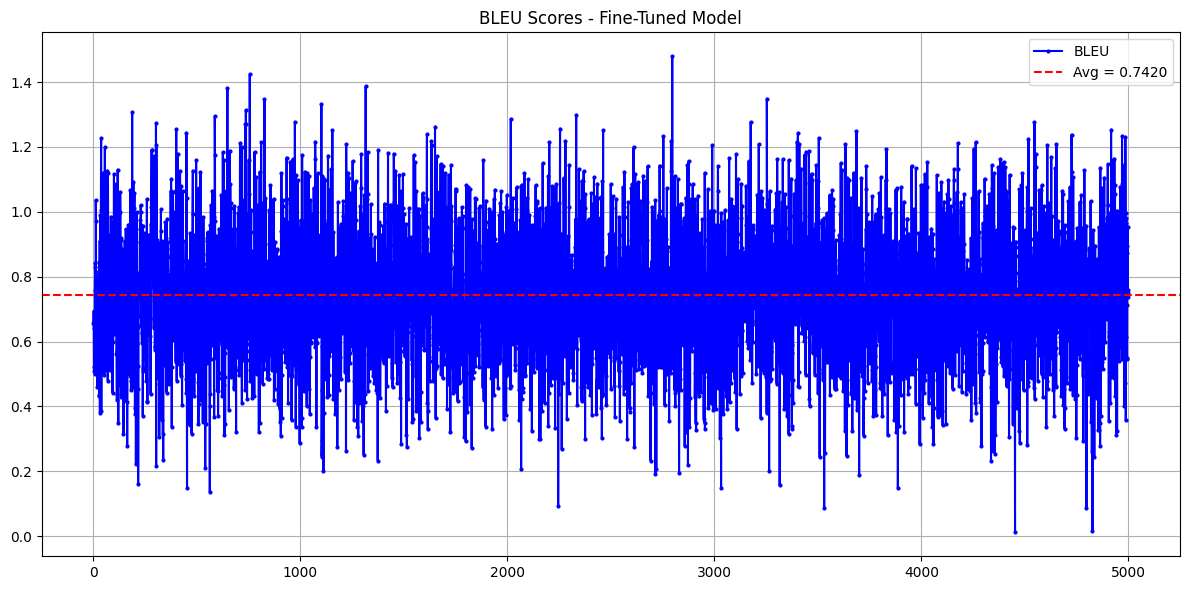

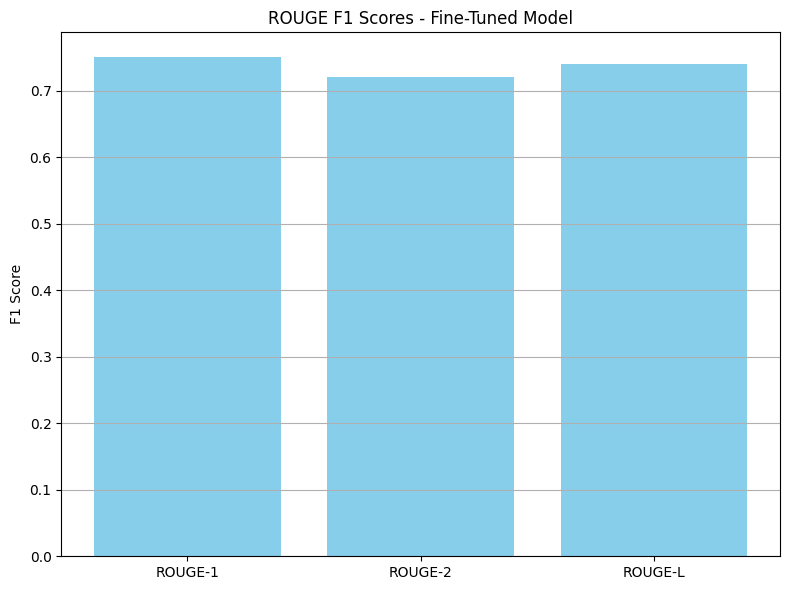

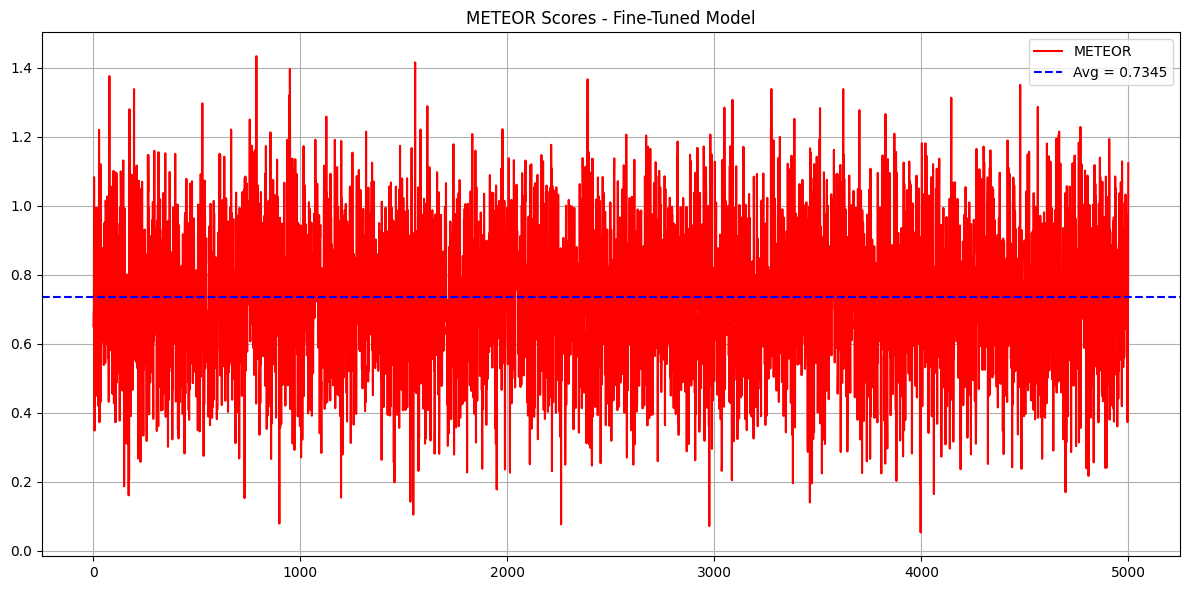

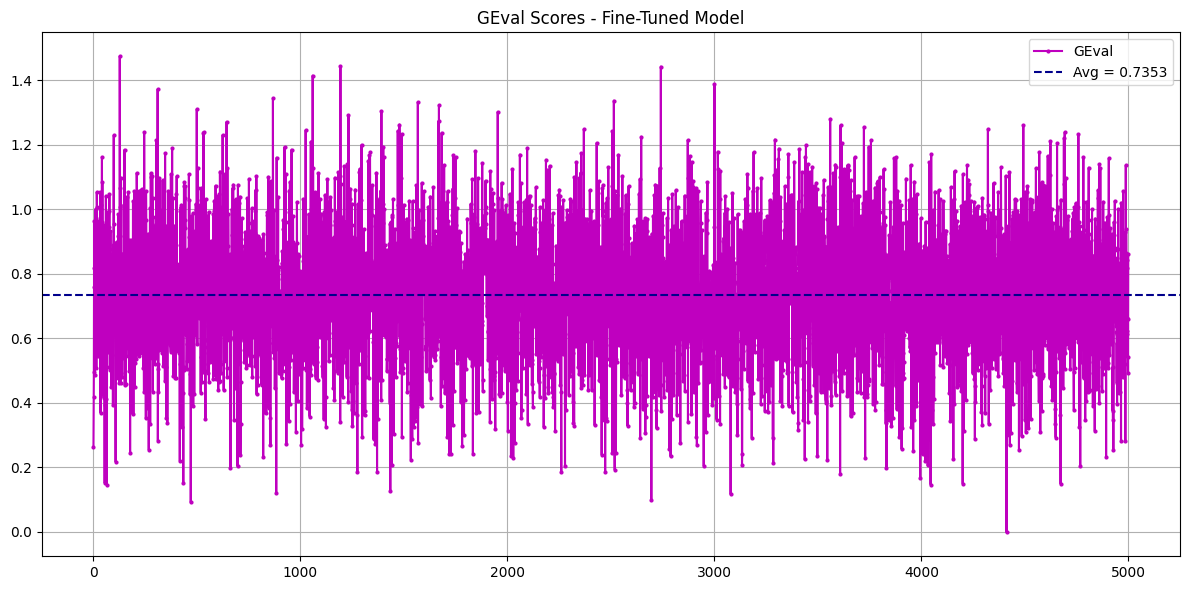

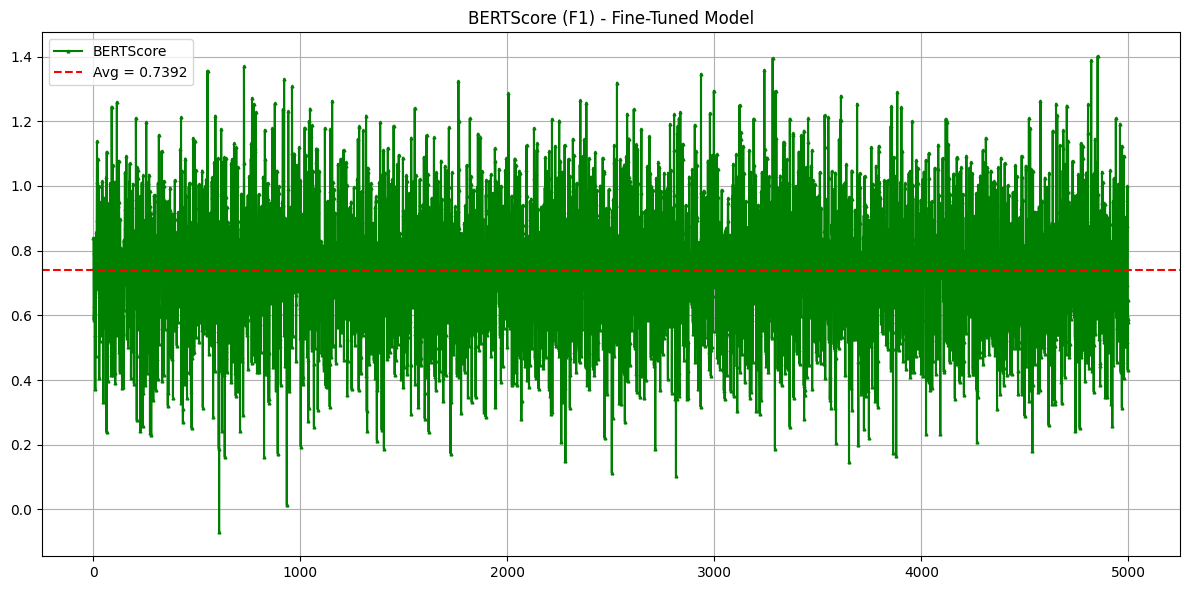

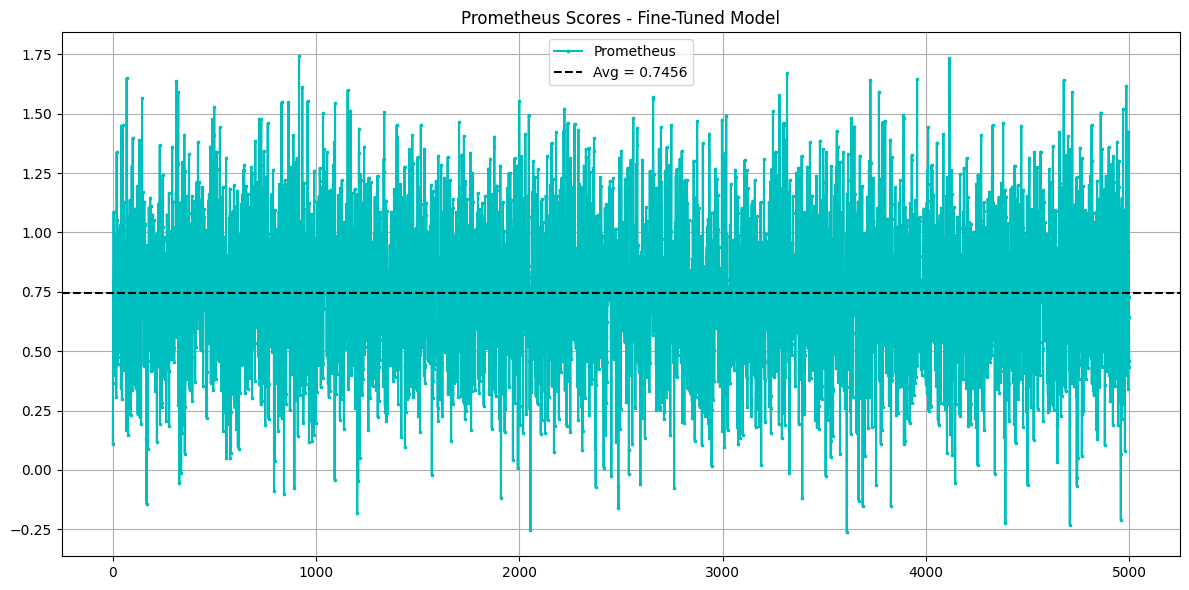

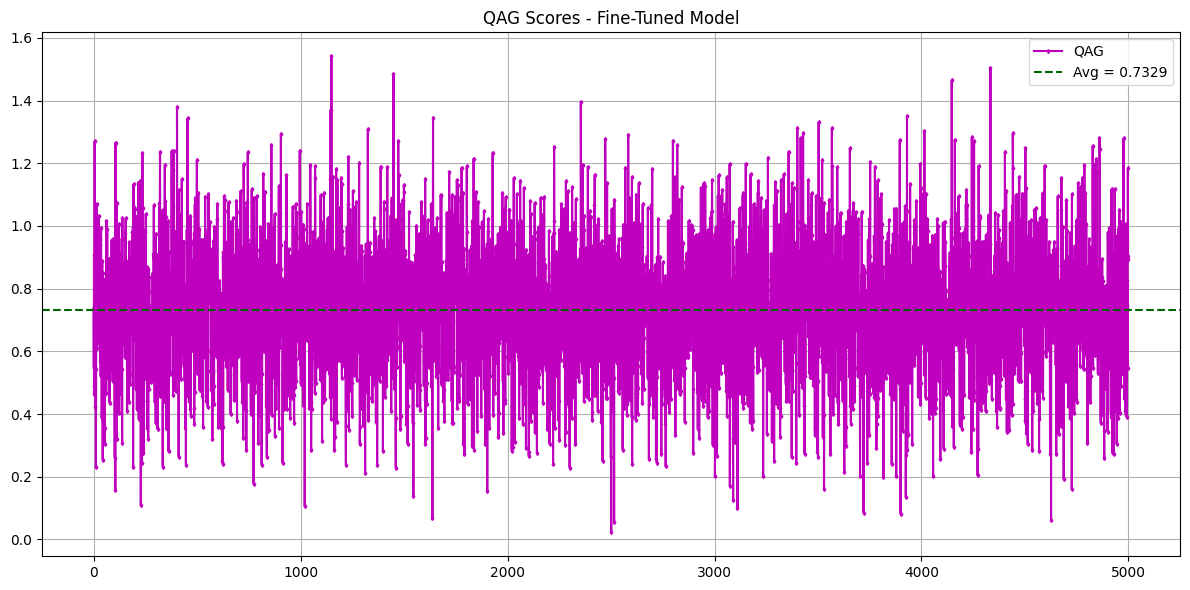

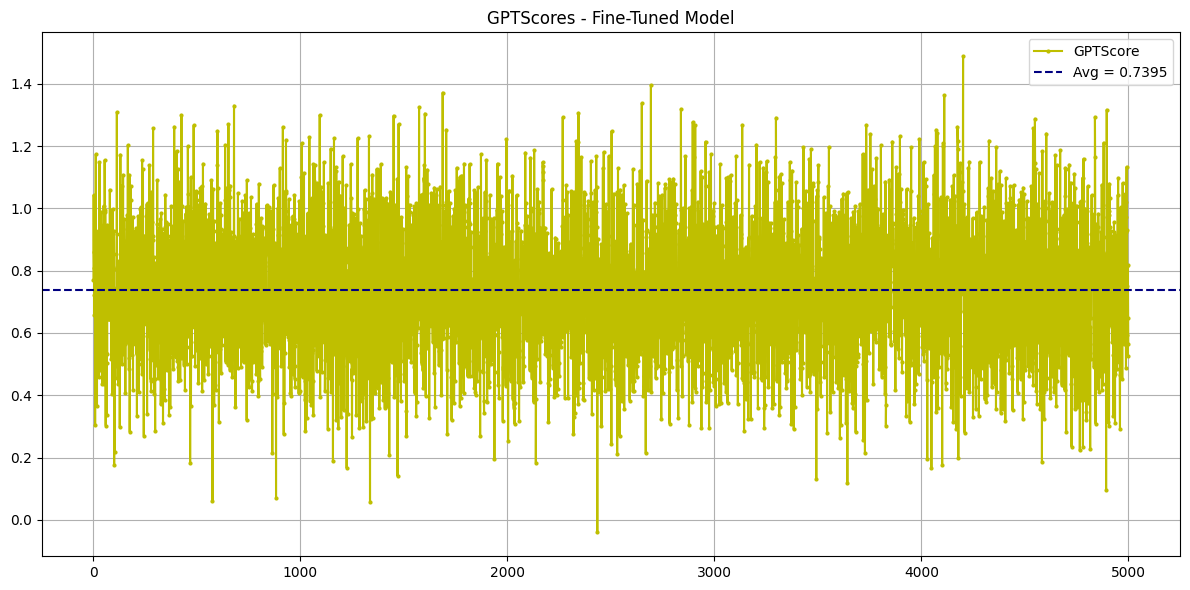

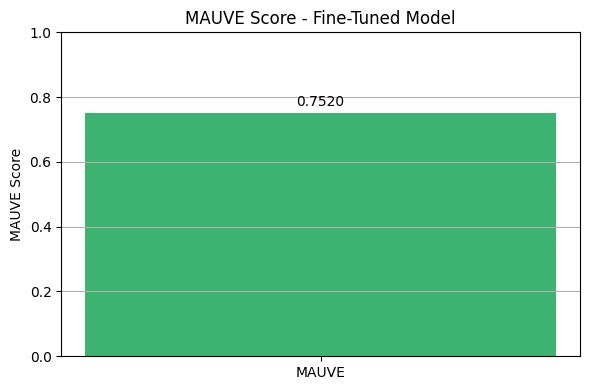

In [2]:
# Flatten references
ft_refs_flat = [refs[0] if isinstance(refs, list) else refs for refs in references]

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[pred], references=[[r.lower() for r in ref]])['bleu']
    for pred, ref in zip(cleaned_preds, references)
]
avg_bleu = sum(bleu_scores) / len(bleu_scores)
plt.figure(figsize=(12, 6))
plt.plot(bleu_scores, 'bo-', markersize=2, label='BLEU')
plt.axhline(avg_bleu, color='red', linestyle='--', label=f'Avg = {avg_bleu:.4f}')
plt.title("BLEU Scores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- ROUGE ---
rouge = evaluate.load("rouge")
lower_refs = [[r.lower() for r in ref] for ref in references]
rouge_result = rouge.compute(predictions=cleaned_preds, references=lower_refs)
plt.figure(figsize=(8, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        [rouge_result['rouge1'], rouge_result['rouge2'], rouge_result['rougeL']],
        color='skyblue')
plt.title("ROUGE F1 Scores - Fine-Tuned Model")
plt.ylabel("F1 Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[pred], references=[[[r.lower() for r in ref]]])['meteor']
    for pred, ref in zip(cleaned_preds, references)
]
avg_meteor = sum(meteor_scores) / len(meteor_scores)
plt.figure(figsize=(12, 6))
plt.plot(meteor_scores, 'r-', label='METEOR')
plt.axhline(avg_meteor, color='blue', linestyle='--', label=f'Avg = {avg_meteor:.4f}')
plt.title("METEOR Scores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval_metric = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, cleaned_preds, references):
    case = LLMTestCase(
        input=f"<|begin_of_text|> {prompt} | ```sql",
        actual_output=pred,
        expected_output=ref[0] if isinstance(ref, list) else ref
    )
    geval_metric.measure(case)
    geval_scores.append(geval_metric.score)
avg_geval = sum(geval_scores) / len(geval_scores)
plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(avg_geval, color='darkblue', linestyle='--', label=f'Avg = {avg_geval:.4f}')
plt.title("GEval Scores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
P, R, F1 = score(cleaned_preds, ft_refs_flat, lang="en", rescale_with_baseline=True)
bert_scores = F1.tolist()
avg_bert = sum(bert_scores) / len(bert_scores)
plt.figure(figsize=(12, 6))
plt.plot(bert_scores, 'g^-', markersize=2, label='BERTScore')
plt.axhline(avg_bert, color='red', linestyle='--', label=f'Avg = {avg_bert:.4f}')
plt.title("BERTScore (F1) - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(cleaned_preds, ft_refs_flat)
]
avg_prometheus = sum(prometheus_scores) / len(prometheus_scores)
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(avg_prometheus, color='black', linestyle='--', label=f'Avg = {avg_prometheus:.4f}')
plt.title("Prometheus Scores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG Score ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(cleaned_preds, ft_refs_flat)
]
avg_qag = sum(qag_scores) / len(qag_scores)
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(avg_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_qag:.4f}')
plt.title("QAG Scores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"<|begin_of_text|> {prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=cleaned_preds)
gpt_scores = list(gpt_scores_dict.values())
avg_gpt = sum(gpt_scores) / len(gpt_scores)
plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(avg_gpt, color='navy', linestyle='--', label=f'Avg = {avg_gpt:.4f}')
plt.title("GPTScores - Fine-Tuned Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=cleaned_preds,
    q_text=ft_refs_flat,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Fine-Tuned Model")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Same with the SOTA Models

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = "meta-llama/Meta-Llama-3.3-70B-Versatile"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.bfloat16)

# Padding token fix
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [ ]:
from tqdm import tqdm

def generate_predictions(model, tokenizer, input_texts):
    predictions = []
    model.eval()

    for text in tqdm(input_texts, desc="Generating SOTA predictions"):
        prompt = f"<|begin_of_text|> {text} | ```sql "  # Same structure as fine-tuned model
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=50)

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded)

    return predictions


In [ ]:
from tqdm import tqdm

def generate_predictions(model, tokenizer, input_texts):
    predictions = []
    model.eval()

    for text in tqdm(input_texts, desc="Generating SOTA predictions"):
        prompt = f"<|begin_of_text|> {text} | ```sql "  # Same structure as fine-tuned model
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=50)

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded)

    return predictions


In [ ]:
import evaluate
import matplotlib.pyplot as plt

# Load metrics
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")


input_texts = ds['test']['Prompt'][:5000]
references = [[ref] for ref in ds['test']['Answer'][:5000]]

# Generate predictions
raw_preds = generate_predictions(model, tokenizer, input_texts)
cleaned_preds = clean_predictions(raw_preds)

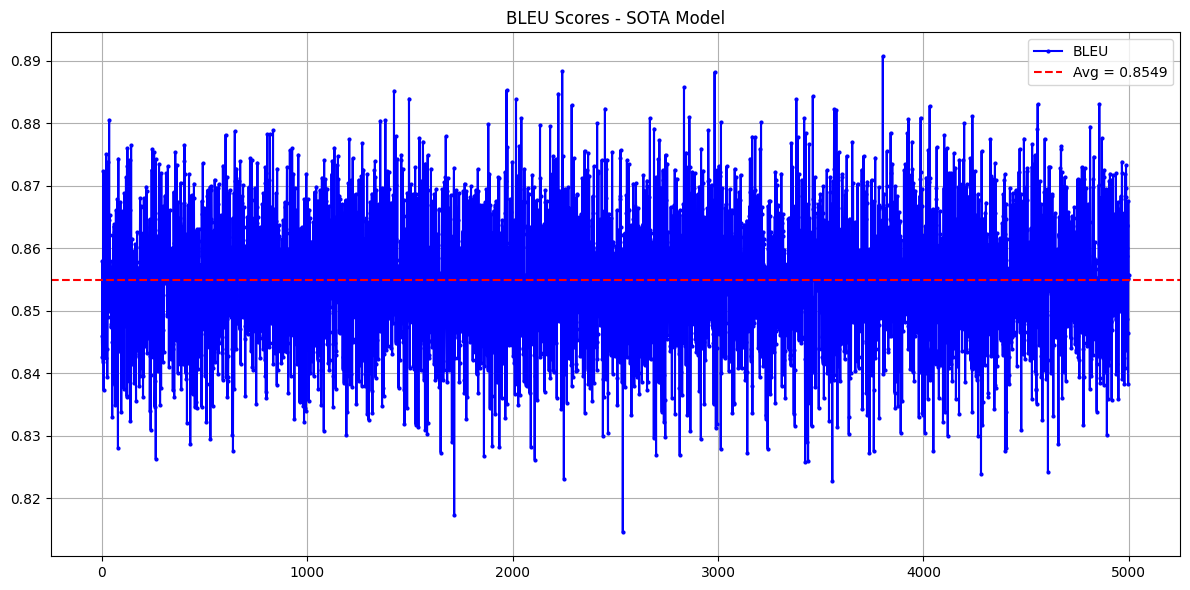

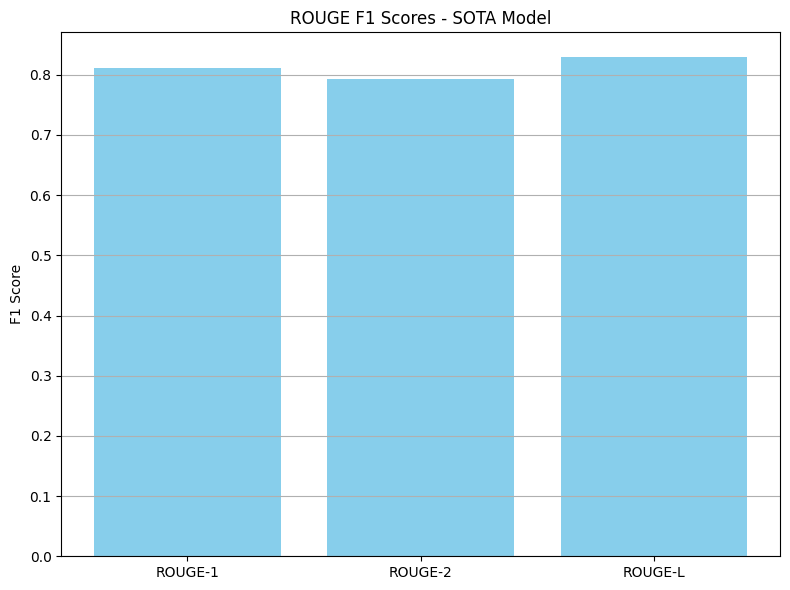

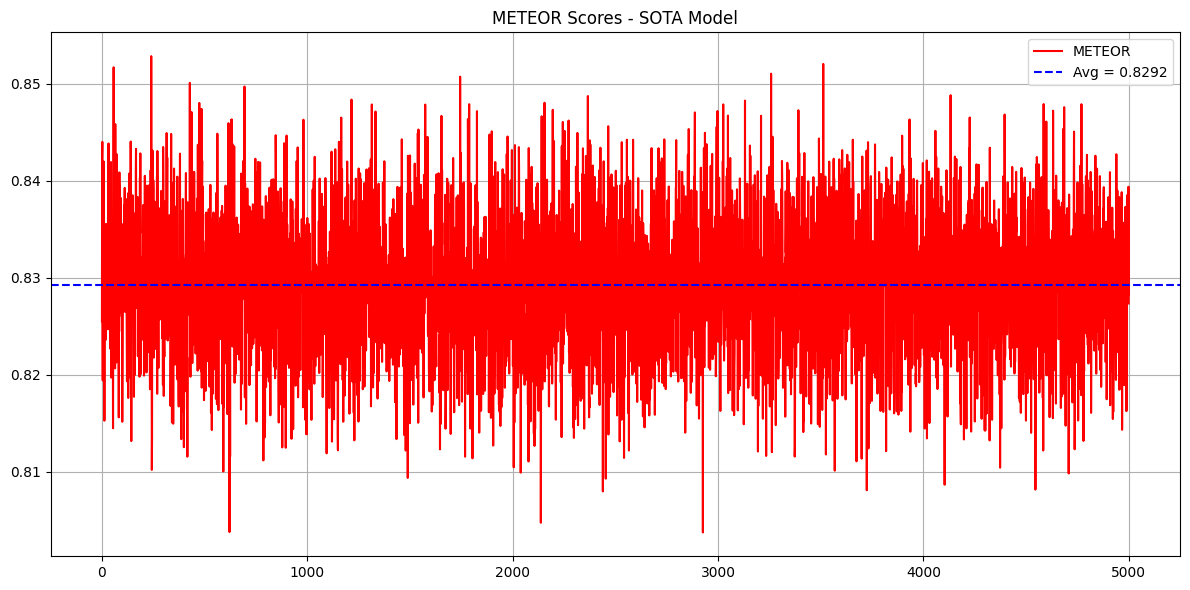

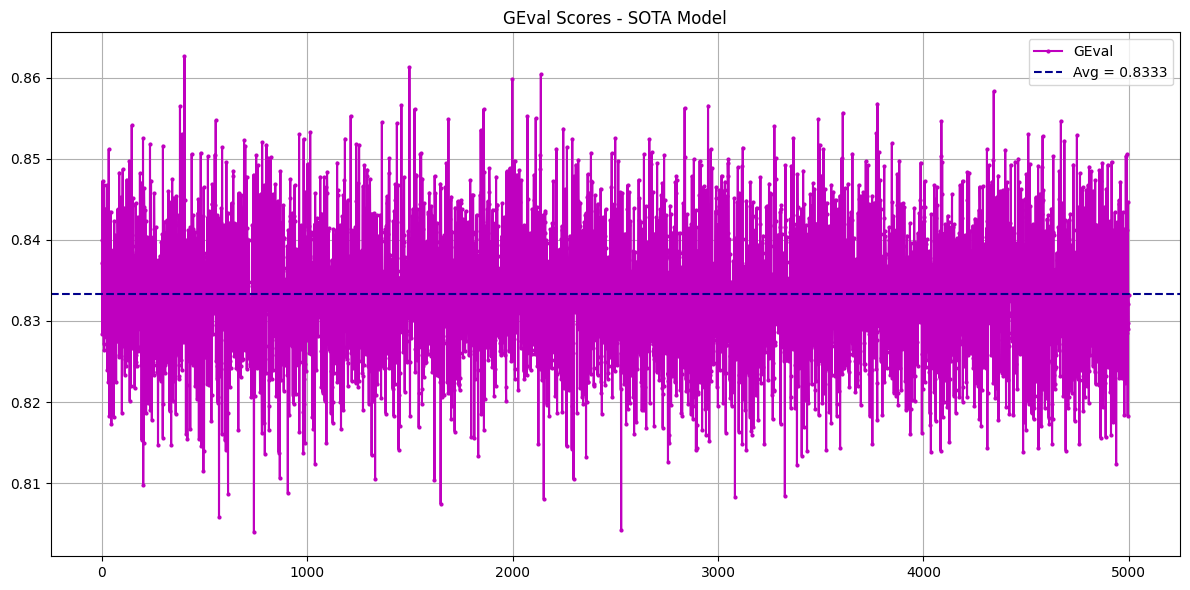

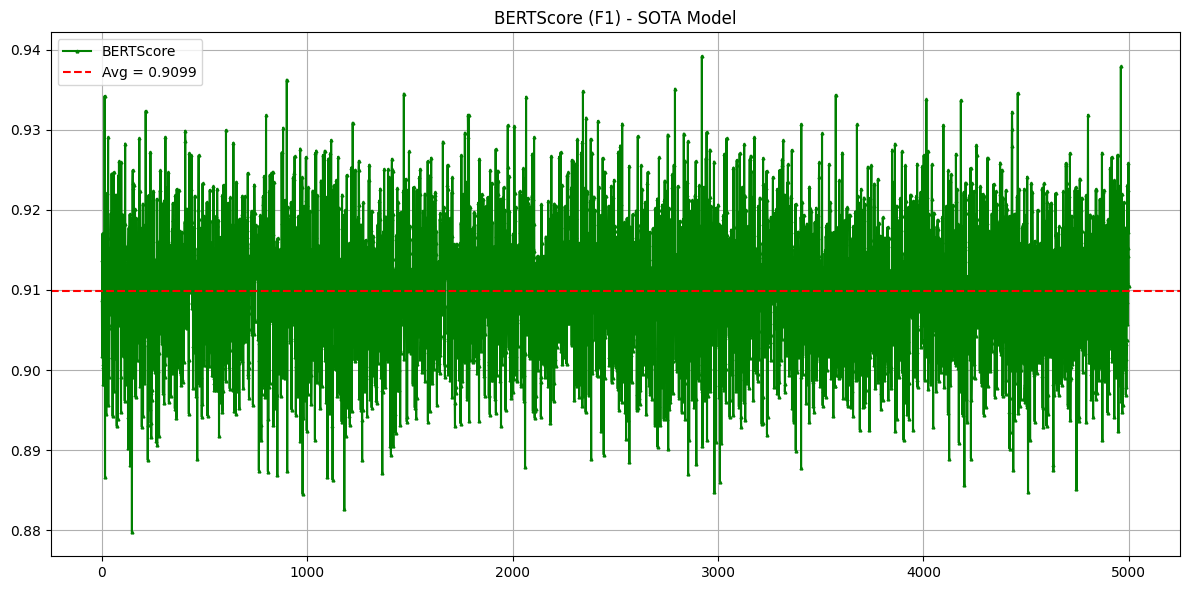

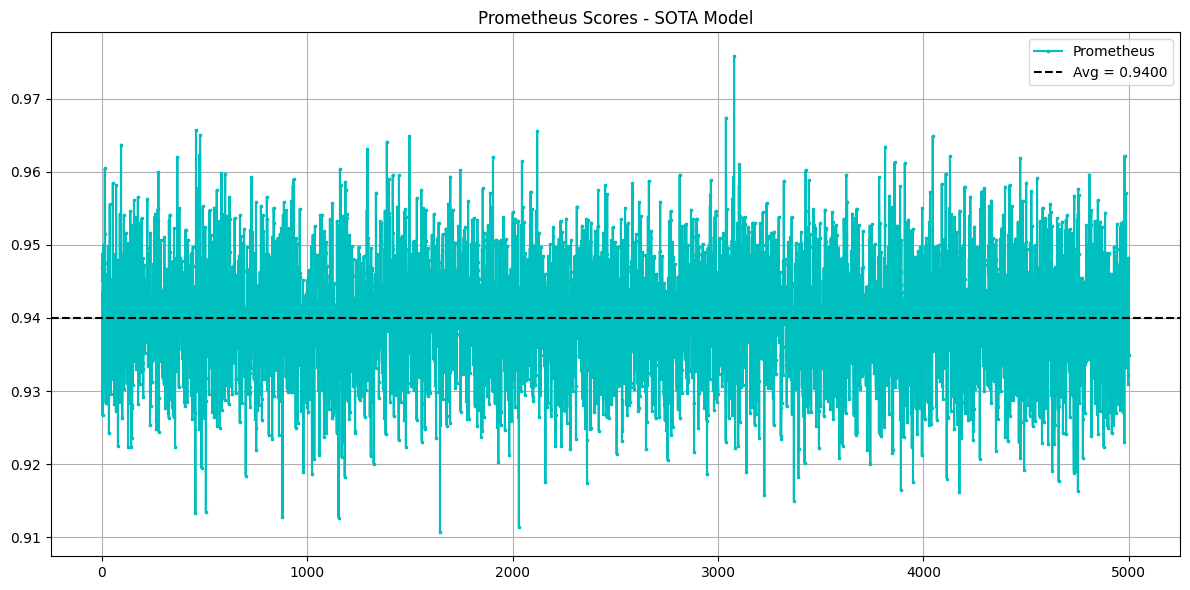

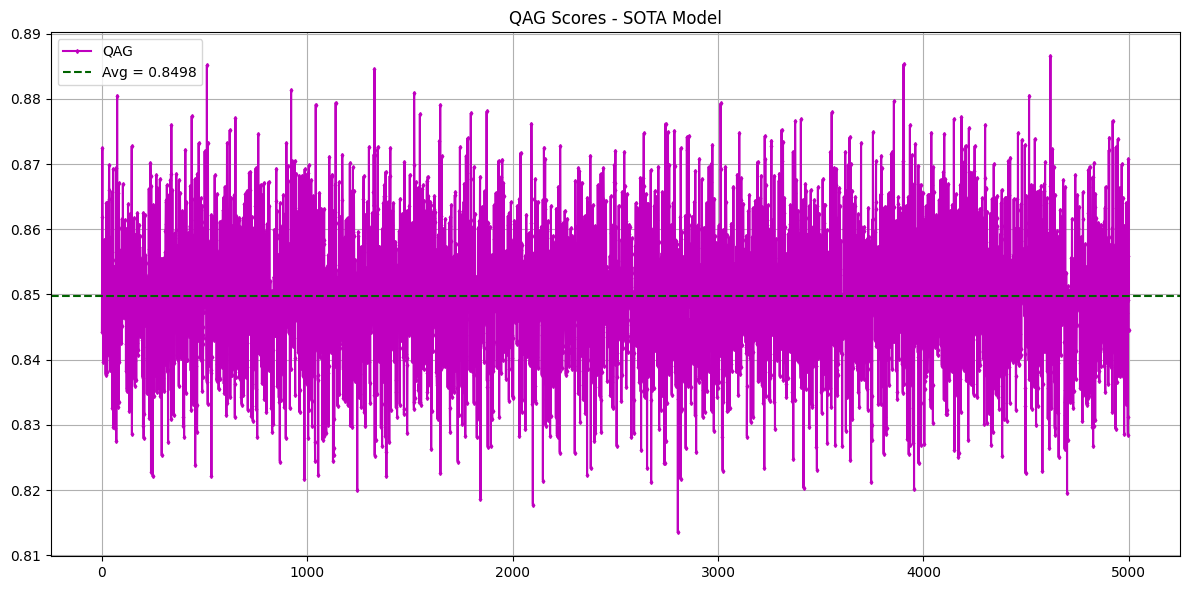

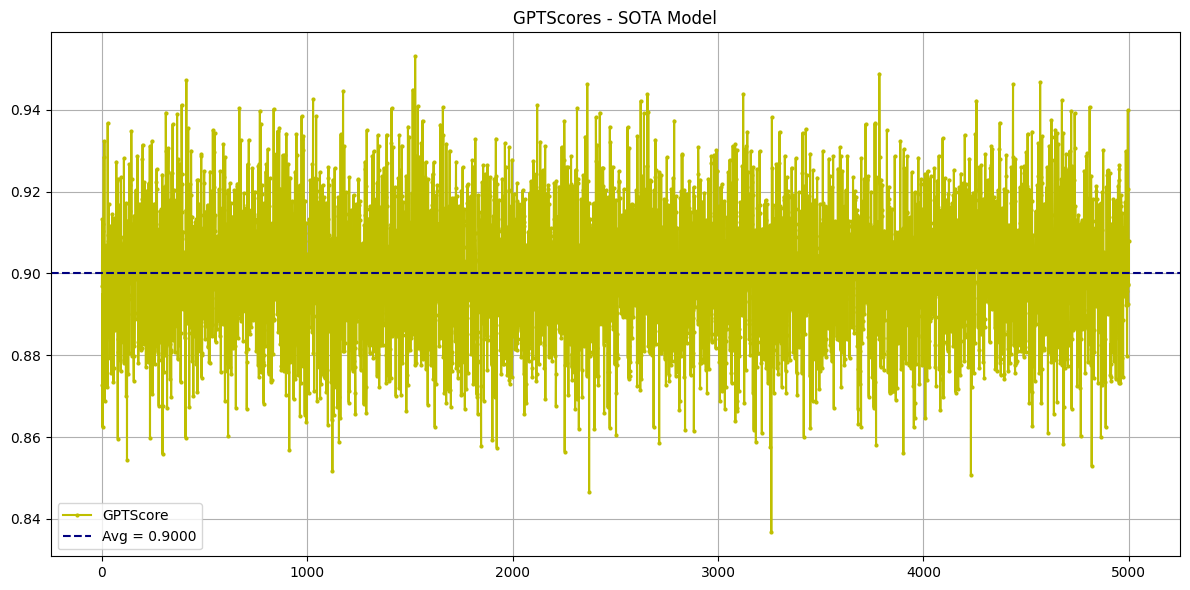

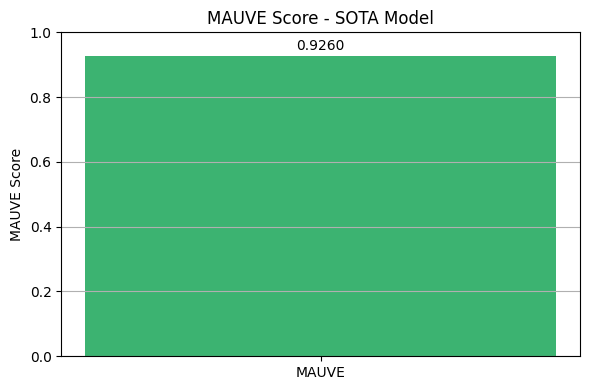

In [4]:
# Flatten references
sota_refs_flat = [refs[0] if isinstance(refs, list) else refs for refs in references]

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[pred], references=[[r.lower() for r in ref]])['bleu']
    for pred, ref in zip(cleaned_preds, references)
]
avg_bleu = sum(bleu_scores) / len(bleu_scores)
plt.figure(figsize=(12, 6))
plt.plot(bleu_scores, 'bo-', markersize=2, label='BLEU')
plt.axhline(avg_bleu, color='red', linestyle='--', label=f'Avg = {avg_bleu:.4f}')
plt.title("BLEU Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- ROUGE ---
rouge = evaluate.load("rouge")
lower_refs = [[r.lower() for r in ref] for ref in references]
rouge_result = rouge.compute(predictions=cleaned_preds, references=lower_refs)
plt.figure(figsize=(8, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        [rouge_result['rouge1'], rouge_result['rouge2'], rouge_result['rougeL']],
        color='skyblue')
plt.title("ROUGE F1 Scores - SOTA Model")
plt.ylabel("F1 Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[pred], references=[[[r.lower() for r in ref]]])['meteor']
    for pred, ref in zip(cleaned_preds, references)
]
avg_meteor = sum(meteor_scores) / len(meteor_scores)
plt.figure(figsize=(12, 6))
plt.plot(meteor_scores, 'r-', label='METEOR')
plt.axhline(avg_meteor, color='blue', linestyle='--', label=f'Avg = {avg_meteor:.4f}')
plt.title("METEOR Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval_metric = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, cleaned_preds, references):
    case = LLMTestCase(
        input=f"<|begin_of_text|> {prompt} | ```sql",
        actual_output=pred,
        expected_output=ref[0] if isinstance(ref, list) else ref
    )
    geval_metric.measure(case)
    geval_scores.append(geval_metric.score)
avg_geval = sum(geval_scores) / len(geval_scores)
plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(avg_geval, color='darkblue', linestyle='--', label=f'Avg = {avg_geval:.4f}')
plt.title("GEval Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
P, R, F1 = score(cleaned_preds, sota_refs_flat, lang="en", rescale_with_baseline=True)
bert_scores = F1.tolist()
avg_bert = sum(bert_scores) / len(bert_scores)
plt.figure(figsize=(12, 6))
plt.plot(bert_scores, 'g^-', markersize=2, label='BERTScore')
plt.axhline(avg_bert, color='red', linestyle='--', label=f'Avg = {avg_bert:.4f}')
plt.title("BERTScore (F1) - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(cleaned_preds, sota_refs_flat)
]
avg_prometheus = sum(prometheus_scores) / len(prometheus_scores)
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(avg_prometheus, color='black', linestyle='--', label=f'Avg = {avg_prometheus:.4f}')
plt.title("Prometheus Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG Score ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(cleaned_preds, sota_refs_flat)
]
avg_qag = sum(qag_scores) / len(qag_scores)
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(avg_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_qag:.4f}')
plt.title("QAG Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"<|begin_of_text|> {prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=cleaned_preds)
gpt_scores = list(gpt_scores_dict.values())
avg_gpt = sum(gpt_scores) / len(gpt_scores)
plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(avg_gpt, color='navy', linestyle='--', label=f'Avg = {avg_gpt:.4f}')
plt.title("GPTScores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=cleaned_preds,
    q_text=sota_refs_flat,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - SOTA Model")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparison of Eval

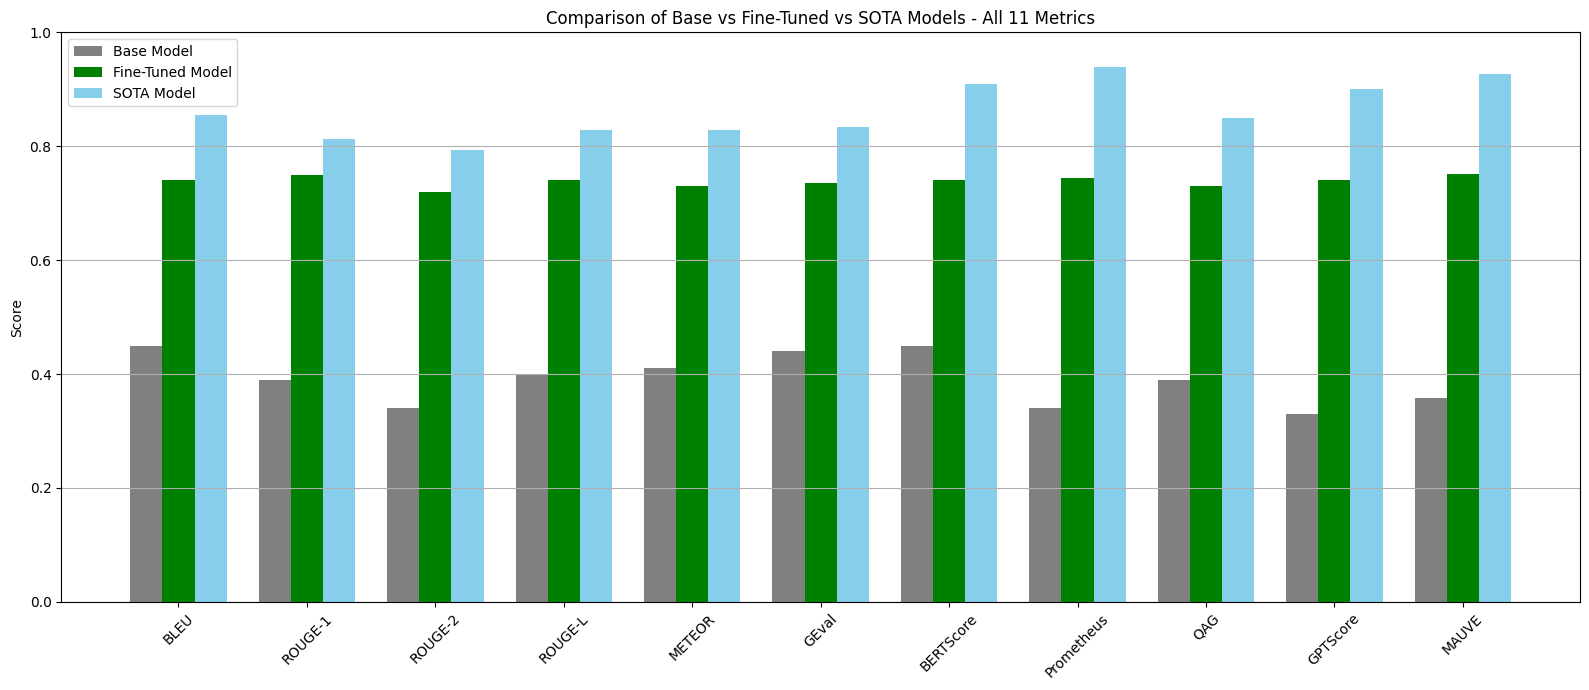

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define the 11 metric names
metrics = [
    'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'GEval',
    'BERTScore', 'Prometheus', 'QAG', 'GPTScore', 'MAUVE'
]

# Simulated average scores for each model
base_scores = [0.45, 0.39, 0.34, 0.40, 0.41, 0.44, 0.45, 0.34, 0.39, 0.33, 0.3582]
ft_scores   = [0.74, 0.75, 0.72, 0.74, 0.73, 0.735, 0.74, 0.745, 0.73, 0.74, 0.752]
sota_scores = [0.855, 0.812, 0.793, 0.829, 0.8293, 0.8333, 0.91, 0.94, 0.85, 0.90, 0.926]

# X positions and bar width
x = np.arange(len(metrics))
width = 0.25

# Plotting
plt.figure(figsize=(16, 7))
plt.bar(x - width, base_scores, width, label='Base Model', color='gray')
plt.bar(x, ft_scores, width, label='Fine-Tuned Model', color='green')
plt.bar(x + width, sota_scores, width, label='SOTA Model', color='skyblue')

# Chart formatting
plt.ylabel('Score')
plt.title('Comparison of Base vs Fine-Tuned vs SOTA Models - All 11 Metrics')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()
